In [1]:
import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
import os
import time
import random

In [2]:
from BaselineSolver import BaselineSolver
from IterativeSolver import IterativeSolver
from GreedySolver import GreedySolver
from GradientDescentSolver import GradientDescentSolver
from utils import run_tests, read_tests_simplex_in_ball, run_random_test, read_tests_simplex_plus_ball_in_ball
from utils import read_tests_degenerate_simplex_in_ball, read_tests_polyhedron_in_ball, read_tests_simplex_in_ball_with_argmaxes
from utils import read_tests_simplex_plus_ball_in_ball_with_argmaxes

In [3]:
support_a, support_b = read_tests_simplex_in_ball_with_argmaxes(f'./tests/3d/simplex-in-ball/10', 3)
solver_instance = GradientDescentSolver(3, support_a, support_b, max_num_iterations=100, learning_rate=1)
solver_instance.solve()

In [4]:
def plot_test_results(times: np.ndarray, t_errors: np.ndarray, title: str, colors: tp.Optional[np.ndarray] = None, fit=True, colorbar_name='delta') -> None:
    t_errors_without_zeros = np.copy(t_errors)
    t_errors_without_zeros[t_errors_without_zeros == 0.] = 1e-16
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    plt.xlabel('time, s')
    plt.ylabel('t_error')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    if colors is not None:
        plt.scatter(times, t_errors_without_zeros, c=colors, cmap='viridis_r', norm=LogNorm())
        plt.colorbar(label=colorbar_name)
    else:
        plt.scatter(times, t_errors_without_zeros)

    if fit:
        a, b = np.polyfit(np.log(times), np.log(t_errors_without_zeros), 1)
        plt.plot(times, np.exp(a * np.log(times) + b), 'r', label=f't_error ~ 1 / time^{-a:.2f}')
        plt.legend()
    plt.title(title)
    plt.savefig(f'figures/{title.replace(" ", "_").replace(",", "")}')

In [ ]:
def get_gd_simplex_in_ball_results(dimension: int, silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for file in sorted(os.listdir(f'./tests/{dimension}d/simplex-in-ball/')):
        support_a, support_b = read_tests_simplex_in_ball_with_argmaxes(f'./tests/{dimension}d/simplex-in-ball/{file}', dimension)
        solver_instance = GradientDescentSolver(dimension, support_a, support_b, max_num_iterations=100, 
                                                max_finding_distinct_minimums_attempts=10, learning_rate=1)
        start_time = time.time()
        solver_instance.solve()
        end_time = time.time()
        times.append(end_time - start_time)
        t_errors.append(abs(1. - solver_instance.t))
        if not silent:
            print(f'test {file}\t time {end_time - start_time}\t t_error {abs(1. - solver_instance.t)}\t num_iterations {solver_instance.iteration}')

    return np.array(times), np.array(t_errors)

In [15]:
def get_gd_simplex_plus_ball_in_ball_results(dimension: int, silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for file in sorted(os.listdir(f'./tests/{dimension}d/simplex-in-ball/')):
        support_a, support_b = read_tests_simplex_plus_ball_in_ball_with_argmaxes(f'./tests/{dimension}d/simplex-plus-ball-in-ball/{file}', dimension)
        solver_instance = GradientDescentSolver(dimension, support_a, support_b, max_num_iterations=20, 
                                                max_finding_distinct_minimums_attempts=10, learning_rate=1)
        start_time = time.time()
        solver_instance.solve()
        end_time = time.time()
        times.append(end_time - start_time)
        t_errors.append(abs(1. - solver_instance.t))
        if not silent:
            print(f'test {file}\t time {end_time - start_time}\t t_error {abs(1. - solver_instance.t)}\t num_iterations {solver_instance.iteration}')

    return np.array(times), np.array(t_errors)

test 1	 time 0.07392334938049316	 t_error 2.220446049250313e-16	 num_iterations 5
test 10	 time 0.019028425216674805	 t_error 0.0	 num_iterations 5
test 100	 time 0.014132499694824219	 t_error 0.0	 num_iterations 5
test 11	 time 0.030141830444335938	 t_error 3.3306690738754696e-16	 num_iterations 6
test 12	 time 0.02427053451538086	 t_error 0.0	 num_iterations 5
test 13	 time 0.16266894340515137	 t_error 1.1102230246251565e-16	 num_iterations 7
test 14	 time 0.015230178833007812	 t_error 0.0	 num_iterations 5
test 15	 time 0.037656545639038086	 t_error 0.0	 num_iterations 5
test 16	 time 0.015757083892822266	 t_error 0.0	 num_iterations 5
test 17	 time 0.11989498138427734	 t_error 1.1102230246251565e-16	 num_iterations 12
test 18	 time 0.0068912506103515625	 t_error 0.0	 num_iterations 5
test 19	 time 0.02501225471496582	 t_error 2.220446049250313e-16	 num_iterations 5
test 2	 time 0.1884772777557373	 t_error 4.440892098500626e-16	 num_iterations 5
test 20	 time 0.02569746971130371	 t_

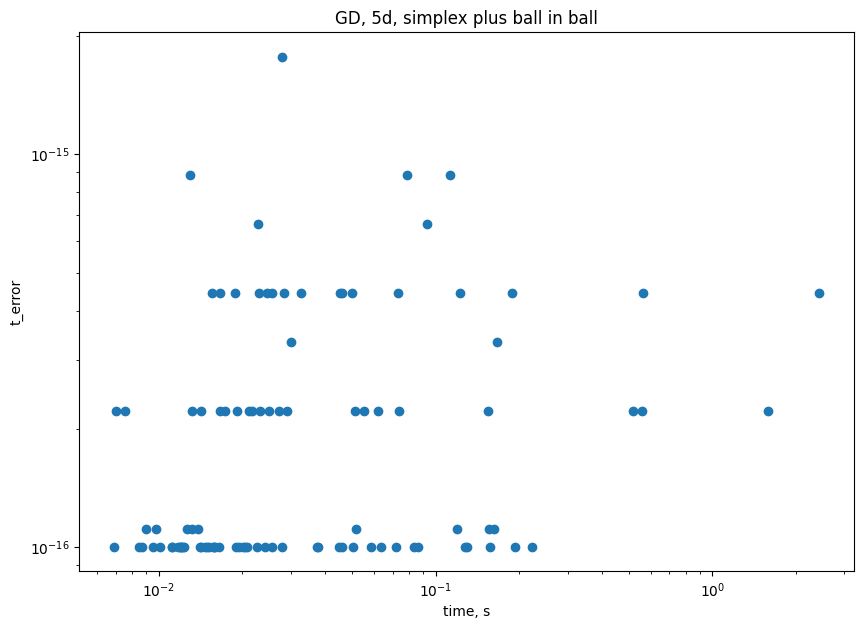

In [8]:
times_gd, errors_gd = get_gd_simplex_plus_ball_in_ball_results(5, silent=False)
plot_test_results(times_gd, errors_gd, 'GD, 5d, simplex plus ball in ball', fit=False)

test 1	 time 0.09898805618286133	 t_error 2.220446049250313e-16	 num_iterations 5
test 10	 time 0.03231453895568848	 t_error 0.0	 num_iterations 5
test 100	 time 0.04432177543640137	 t_error 0.0	 num_iterations 5
test 11	 time 0.032901763916015625	 t_error 2.220446049250313e-16	 num_iterations 5
test 12	 time 0.030595064163208008	 t_error 4.440892098500626e-16	 num_iterations 5
test 13	 time 0.05573225021362305	 t_error 4.440892098500626e-16	 num_iterations 5
test 14	 time 0.08672237396240234	 t_error 6.661338147750939e-16	 num_iterations 5
test 15	 time 0.03840041160583496	 t_error 0.0	 num_iterations 5
test 16	 time 0.2428147792816162	 t_error 4.440892098500626e-16	 num_iterations 5
test 17	 time 0.06442427635192871	 t_error 1.1102230246251565e-16	 num_iterations 5
test 18	 time 0.2046971321105957	 t_error 0.0	 num_iterations 5
test 19	 time 0.06218695640563965	 t_error 0.0	 num_iterations 5
test 2	 time 0.1212160587310791	 t_error 1.1102230246251565e-15	 num_iterations 5
test 20	 ti

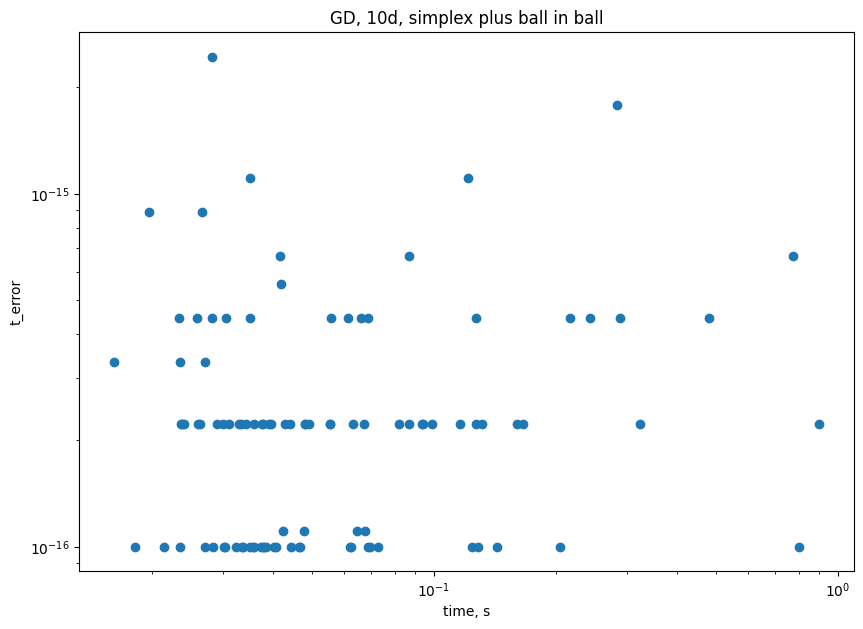

In [9]:
times_gd, errors_gd = get_gd_simplex_plus_ball_in_ball_results(10, silent=False)
plot_test_results(times_gd, errors_gd, 'GD, 10d, simplex plus ball in ball', fit=False)

test 1	 time 0.13470864295959473	 t_error 0.0	 num_iterations 5
test 10	 time 0.07555532455444336	 t_error 5.551115123125783e-16	 num_iterations 5
test 100	 time 0.08571982383728027	 t_error 9.992007221626409e-16	 num_iterations 5
test 11	 time 0.20658564567565918	 t_error 0.0	 num_iterations 5
test 12	 time 0.05744314193725586	 t_error 0.0	 num_iterations 5
test 13	 time 0.3383498191833496	 t_error 4.440892098500626e-16	 num_iterations 5
test 14	 time 0.09408402442932129	 t_error 0.0	 num_iterations 5
test 15	 time 0.0719304084777832	 t_error 0.0	 num_iterations 5
test 16	 time 0.07077932357788086	 t_error 6.661338147750939e-16	 num_iterations 5
test 17	 time 0.07498526573181152	 t_error 2.220446049250313e-16	 num_iterations 6
test 18	 time 0.10362553596496582	 t_error 2.220446049250313e-16	 num_iterations 5
test 19	 time 0.062308311462402344	 t_error 3.3306690738754696e-16	 num_iterations 5
test 2	 time 0.061313629150390625	 t_error 8.881784197001252e-16	 num_iterations 6
test 20	 ti

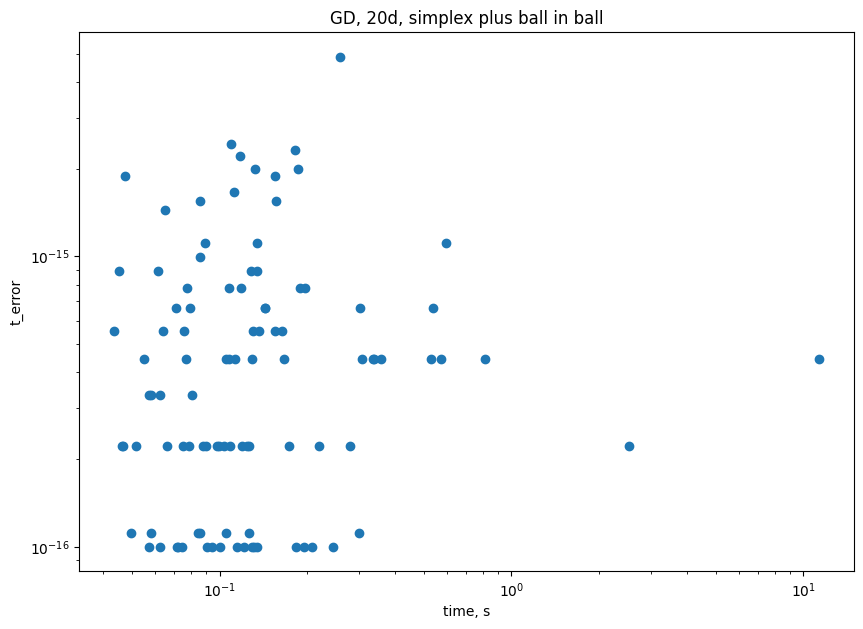

In [11]:
times_gd, errors_gd = get_gd_simplex_plus_ball_in_ball_results(20, silent=False)
plot_test_results(times_gd, errors_gd, 'GD, 20d, simplex plus ball in ball', fit=False)

test 1	 time 0.26169276237487793	 t_error 5.551115123125783e-16	 num_iterations 5
test 10	 time 0.26874852180480957	 t_error 2.220446049250313e-16	 num_iterations 5
test 100	 time 0.28551745414733887	 t_error 1.3322676295501878e-15	 num_iterations 5
test 11	 time 0.2816452980041504	 t_error 3.3306690738754696e-16	 num_iterations 5
test 12	 time 0.30701184272766113	 t_error 1.7763568394002505e-15	 num_iterations 5
test 13	 time 0.2667880058288574	 t_error 2.220446049250313e-16	 num_iterations 5
test 14	 time 0.34595775604248047	 t_error 3.885780586188048e-15	 num_iterations 5
test 15	 time 0.3182504177093506	 t_error 1.7763568394002505e-15	 num_iterations 5
test 16	 time 0.3592808246612549	 t_error 6.217248937900877e-15	 num_iterations 9
test 17	 time 0.26594090461730957	 t_error 4.440892098500626e-16	 num_iterations 5
test 18	 time 0.30704307556152344	 t_error 4.440892098500626e-16	 num_iterations 6
test 19	 time 0.3077731132507324	 t_error 1.5543122344752192e-15	 num_iterations 5
test

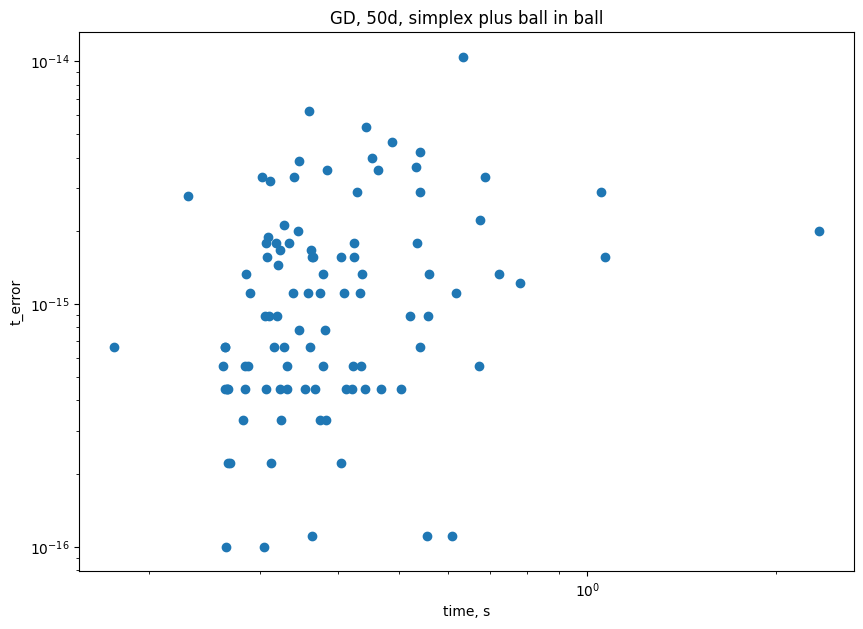

In [12]:
times_gd, errors_gd = get_gd_simplex_plus_ball_in_ball_results(50, silent=False)
plot_test_results(times_gd, errors_gd, 'GD, 50d, simplex plus ball in ball', fit=False)

test 1	 time 1.821876049041748	 t_error 3.219646771412954e-15	 num_iterations 5
test 10	 time 1.0464138984680176	 t_error 4.551914400963142e-15	 num_iterations 5
test 100	 time 1.4140784740447998	 t_error 4.440892098500626e-16	 num_iterations 5
test 11	 time 1.2447278499603271	 t_error 8.43769498715119e-15	 num_iterations 5
test 12	 time 1.5095834732055664	 t_error 1.2212453270876722e-15	 num_iterations 5
test 13	 time 1.5449633598327637	 t_error 1.9984014443252818e-15	 num_iterations 5
test 14	 time 1.544755458831787	 t_error 7.771561172376096e-16	 num_iterations 5
test 15	 time 1.4290735721588135	 t_error 2.220446049250313e-16	 num_iterations 5
test 16	 time 1.4134035110473633	 t_error 1.4432899320127035e-15	 num_iterations 5
test 17	 time 1.7257943153381348	 t_error 6.8833827526759706e-15	 num_iterations 5
test 18	 time 1.4008195400238037	 t_error 4.440892098500626e-16	 num_iterations 5
test 19	 time 1.7117714881896973	 t_error 2.6645352591003757e-15	 num_iterations 5
test 2	 time 2

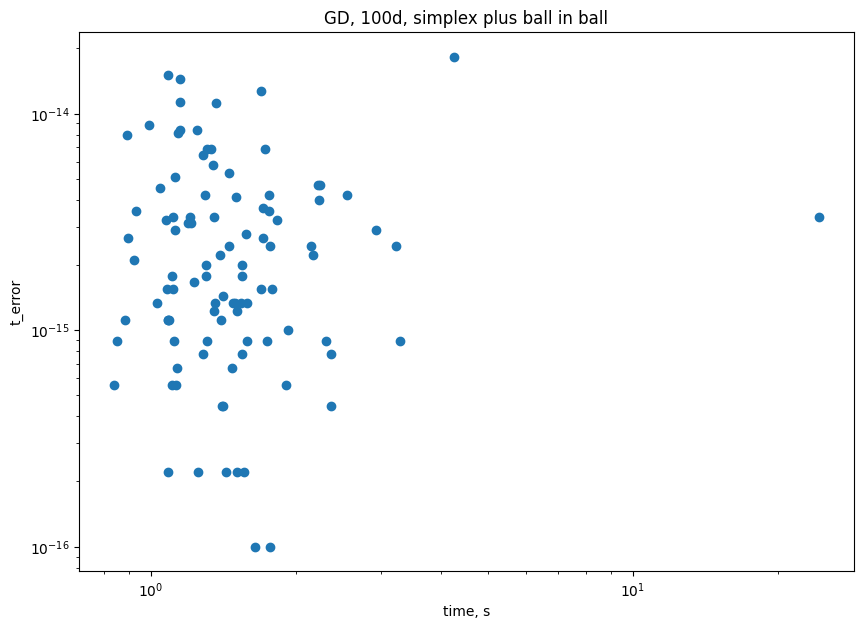

In [17]:
times_gd, errors_gd = get_gd_simplex_plus_ball_in_ball_results(100, silent=False)
plot_test_results(times_gd, errors_gd, 'GD, 100d, simplex plus ball in ball', fit=False)

times_gd_2d, errors_gd_2d = get_gd_simplex_in_ball_results(2, silent=True)
plot_test_results(times_gd_2d, errors_gd_2d, 'GD, 2d, simplex in ball', fit=False)

times_gd, errors_gd = get_gd_simplex_in_ball_results(3, silent=False)
plot_test_results(times_gd, errors_gd, 'GD, 3d, simplex in ball', fit=False)

times_gd, errors_gd = get_gd_simplex_in_ball_results(4, silent=False)
plot_test_results(times_gd, errors_gd, 'GD, 4d, simplex in ball', fit=False)

times_gd, errors_gd = get_gd_simplex_in_ballшш_results(5, silent=False)
plot_test_results(times_gd, errors_gd, 'GD, 5d, simplex in ball', fit=False)

times_gd, errors_gd = get_gd_simplex_in_ball_results(10, silent=False)
plot_test_results(times_gd, errors_gd, 'GD, 10d, simplex in ball', fit=False)

times_gd, errors_gd = get_gd_simplex_in_ball_results(20, silent=False)
plot_test_results(times_gd, errors_gd, 'GD, 20d, simplex in ball', fit=False)

times_gd, errors_gd = get_gd_simplex_in_ball_results(50, silent=False)
plot_test_results(times_gd, errors_gd, 'GD, 50d, simplex in ball', fit=False)

times_gd, errors_gd = get_gd_simplex_in_ball_results(100, silent=False)
plot_test_results(times_gd, errors_gd, 'GD, 100d, simplex in ball', fit=False)

In [ ]:
%load_ext line_profiler

In [ ]:
file = random.choice(os.listdir('./tests/10d/simplex-in-ball/')) 
support_a, support_b, delta = read_tests_simplex_in_ball(f'./tests/10d/simplex-in-ball/{file}', 10) 
GradientDescentSolver(10, support_a, support_b, max_num_iterations=100, 
                                                max_finding_distinct_minimums_attempts=10, learning_rate=1)
%prun solver_instance.solve()

In [ ]:
def get_baseline_test_results(dimension: int, number_tests: int, lowest_grid_density: float=100, highest_grid_density: float=10000,
                             silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for _ in range(number_tests):
        time, t_error = run_random_test(BaselineSolver, dimension, 
                                        {'grid_density': np.exp(np.random.uniform(np.log(lowest_grid_density), np.log(highest_grid_density)))}, 
                                        read_tests_simplex_in_ball, f'./tests/{dimension}d/simplex-in-ball/', silent=silent)
        times.append(time)
        t_errors.append(t_error)
    
    return np.array(times), np.array(t_errors)

In [ ]:
def get_iterative_test_results(dimension: int, number_tests: int, lowest_cap_grid_diameter: int=3, 
                               highest_cap_grid_diameter: int=10,
                              silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for _ in range(number_tests):
        cap_grid_diameter = int(np.round(np.exp(np.random.uniform(np.log(lowest_cap_grid_diameter), np.log(highest_cap_grid_diameter)))))
        time, t_error = run_random_test(IterativeSolver, dimension, 
                                        {'cap_grid_diameter': cap_grid_diameter}, 
                                        read_tests_simplex_in_ball, f'./tests/{dimension}d/simplex-in-ball/', silent=silent)
        times.append(time)
        t_errors.append(t_error)
    
    return np.array(times), np.array(t_errors)

In [ ]:
def get_greedy_simplex_in_ball_results(dimension: int, lowest_max_iteration: int=80, highest_max_iteration: int=80, 
                            silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    deltas = []
    for file in sorted(os.listdir(f'./tests/{dimension}d/simplex-in-ball/')):
        support_a, support_b, delta = read_tests_simplex_in_ball(f'./tests/{dimension}d/simplex-in-ball/{file}', dimension)
        solver_instance = GreedySolver(dimension, support_a, support_b, 
                                 num_iterations=int(np.exp(np.random.uniform(np.log(lowest_max_iteration), np.log(highest_max_iteration)))))
        start_time = time.time()
        solver_instance.solve()
        end_time = time.time()
        times.append(end_time - start_time)
        t_errors.append(abs(1. - solver_instance.t))
        deltas.append(delta)
        if not silent:
            print(f'test \t{file}\t time \t{end_time - start_time}\t t_error \t{abs(1. - solver_instance.t)}')

    return np.array(times), np.array(t_errors), np.array(deltas)

In [ ]:
def get_greedy_simplex_plus_ball_in_ball_results(dimension: int, lowest_max_iteration: int=100, highest_max_iteration: int=100, 
                            silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    deltas = []
    for file in sorted(os.listdir(f'./tests/{dimension}d/simplex-in-ball/')):
        support_a, support_b, delta = read_tests_simplex_plus_ball_in_ball(f'./tests/{dimension}d/simplex-plus-ball-in-ball/{file}', dimension)
        solver_instance = GreedySolver(dimension, support_a, support_b, 
                                 num_iterations=int(np.exp(np.random.uniform(np.log(lowest_max_iteration), np.log(highest_max_iteration)))))
        start_time = time.time()
        solver_instance.solve()
        end_time = time.time()
        times.append(end_time - start_time)
        t_errors.append(abs(1. - solver_instance.t))
        deltas.append(delta)
        if not silent:
            print(f'test \t{file}\t time \t{end_time - start_time}\t t_error \t{abs(1. - solver_instance.t)}')

    return np.array(times), np.array(t_errors), np.array(deltas)

In [ ]:
def get_greedy_degenerate_simplex_in_ball_results(dimension: int, lowest_max_iteration: int=100, highest_max_iteration: int=100, 
                            silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for file in sorted(os.listdir(f'./tests/{dimension}d/simplex-in-ball/')):
        support_a, support_b = read_tests_degenerate_simplex_in_ball(f'./tests/{dimension}d/degenerate-simplex-in-ball/{file}', dimension)
        solver_instance = GreedySolver(dimension, support_a, support_b, 
                                 num_iterations=int(np.exp(np.random.uniform(np.log(lowest_max_iteration), np.log(highest_max_iteration)))))
        start_time = time.time()
        solver_instance.solve()
        end_time = time.time()
        times.append(end_time - start_time)
        t_errors.append(abs(1. - solver_instance.t))
        if not silent:
            print(f'test \t{file}\t time \t{end_time - start_time}\t t_error \t{abs(1. - solver_instance.t)}')

    return np.array(times), np.array(t_errors)

In [ ]:
def get_greedy_polyhedron_in_ball_results(dimension: int, lowest_max_iteration: int=100, highest_max_iteration: int=100, 
                            silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    d = []
    for file in sorted(os.listdir(f'./tests/{dimension}d/polyhedron-in-ball/')):
        support_a, support_b, current_d = read_tests_polyhedron_in_ball(f'./tests/{dimension}d/polyhedron-in-ball/{file}', dimension)
        solver_instance = GreedySolver(dimension, support_a, support_b, 
                                 num_iterations=int(np.exp(np.random.uniform(np.log(lowest_max_iteration), np.log(highest_max_iteration)))))
        start_time = time.time()
        solver_instance.solve()
        end_time = time.time()
        times.append(end_time - start_time)
        t_errors.append(abs(1. - solver_instance.t))
        d.append(current_d)
        if not silent:
            print(f'test \t{file}\t time \t{end_time - start_time}\t t_error \t{abs(1. - solver_instance.t)}')

    return np.array(times), np.array(t_errors), np.array(d)

file = random.choice(os.listdir('./tests/10d/simplex-in-ball/'))
support_a, support_b, delta = read_tests_simplex_in_ball(f'./tests/10d/simplex-in-ball/{file}', 10)
solver_instance = GreedySolver(10, support_a, support_b, num_iterations=500)

%prun solver_instance.solve()

times_greedy_2d, errors_greedy_2d, d_greedy_2d = get_greedy_polyhedron_in_ball_results(2, silent=True)
plot_test_results(times_greedy_2d, errors_greedy_2d, 'GreedySolver, 2d, polyhedron in ball', fit=False, colors=d_greedy_2d, 
                  colorbar_name='minimal distance from a non-based vertex to the sphere')

times_greedy_3d, errors_greedy_3d, d_greedy_3d = get_greedy_polyhedron_in_ball_results(3, silent=True) 
plot_test_results(times_greedy_3d, errors_greedy_3d, 'GreedySolver, 3d, polyhedron in ball', fit=False, colors=d_greedy_3d, 
                  colorbar_name='minimal distance from a non-based vertex to the sphere')

times_greedy_4d, errors_greedy_4d, d_greedy_4d = get_greedy_polyhedron_in_ball_results(4, silent=True) 
plot_test_results(times_greedy_4d, errors_greedy_4d, 'GreedySolver, 4d, polyhedron in ball', fit=False, colors=d_greedy_4d, 
                  colorbar_name='minimal distance from a non-based vertex to the sphere')

times_greedy_5d, errors_greedy_5d, d_greedy_5d = get_greedy_polyhedron_in_ball_results(5, silent=True) 
plot_test_results(times_greedy_5d, errors_greedy_5d, 'GreedySolver, 5d, polyhedron in ball', fit=False, colors=d_greedy_5d, 
                  colorbar_name='minimal distance from a non-based vertex to the sphere')

times_greedy_10d, errors_greedy_10d, d_greedy_10d = get_greedy_polyhedron_in_ball_results(10, silent=False) 
plot_test_results(times_greedy_10d, errors_greedy_10d, 'GreedySolver, 10d, polyhedron in ball', fit=False, colors=d_greedy_10d, 
                  colorbar_name='minimal distance from a non-based vertex to the sphere')

times_greedy_2d, errors_greedy_2d = get_greedy_degenerate_simplex_in_ball_results(2, silent=True)
plot_test_results(times_greedy_2d, errors_greedy_2d, 'GreedySolver, 2d, degenerate simplex', fit=False)

times_greedy_3d, errors_greedy_3d = get_greedy_degenerate_simplex_in_ball_results(3, silent=True)
plot_test_results(times_greedy_3d, errors_greedy_3d, 'GreedySolver, 3d, degenerate simplex', fit=False)

times_greedy_4d, errors_greedy_4d = get_greedy_degenerate_simplex_in_ball_results(4, silent=True)
plot_test_results(times_greedy_4d, errors_greedy_4d, 'GreedySolver, 4d, degenerate simplex', fit=False)

times_greedy_5d, errors_greedy_5d = get_greedy_degenerate_simplex_in_ball_results(5, silent=True)
plot_test_results(times_greedy_5d, errors_greedy_5d, 'GreedySolver, 5d, degenerate simplex', fit=False)

times_greedy_10d, errors_greedy_10d = get_greedy_degenerate_simplex_in_ball_results(10, silent=False)
plot_test_results(times_greedy_10d, errors_greedy_10d, 'GreedySolver, 10d, degenerate simplex', fit=False)

times_greedy_2d, errors_greedy_2d, deltas_greedy_2d = get_greedy_simplex_plus_ball_in_ball_results(2, silent=True)
plot_test_results(times_greedy_2d, errors_greedy_2d, deltas_greedy_2d, 'GreedySolver, 2d, simplex + ball, 50 iterations', fit=False)

times_greedy_3d, errors_greedy_3d, deltas_greedy_3d = get_greedy_simplex_plus_ball_in_ball_results(3, silent=True)
plot_test_results(times_greedy_3d, errors_greedy_3d, deltas_greedy_3d, 'GreedySolver, 3d, simplex + ball, 50 iterations', fit=False)

times_greedy_4d, errors_greedy_4d, deltas_greedy_4d = get_greedy_simplex_plus_ball_in_ball_results(4, silent=True)
plot_test_results(times_greedy_4d, errors_greedy_4d, deltas_greedy_4d, 'GreedySolver, 4d, simplex + ball, 50 iterations', fit=False)

times_greedy_5d, errors_greedy_5d, deltas_greedy_5d = get_greedy_simplex_plus_ball_in_ball_results(5, silent=True)
plot_test_results(times_greedy_5d, errors_greedy_5d, deltas_greedy_5d, 'GreedySolver, 5d, simplex + ball, 80 iterations', fit=False)

times_greedy_10d, errors_greedy_10d, deltas_greedy_10d = get_greedy_simplex_plus_ball_in_ball_results(10, silent=False)
plot_test_results(times_greedy_10d, errors_greedy_10d, deltas_greedy_10d, 'GreedySolver, 10d, simplex + ball, 100 iterations', fit=False)

times_greedy_2d, errors_greedy_2d, deltas_greedy_2d = get_greedy_test_results(2, silent=False)
plot_test_results(times_greedy_2d, errors_greedy_2d, deltas_greedy_2d, 'GreedySolver, 2d, n(n+1) caps with heuristic, random inscribed simplex', fit=False)

times_greedy_3d, errors_greedy_3d, deltas_greedy_3d = get_greedy_test_results(3, silent=False)
plot_test_results(times_greedy_3d, errors_greedy_3d, deltas_greedy_3d, 'GreedySolver, 3d, n(n+1) caps with heuristic, random inscribed simplex', fit=False)

times_greedy_4d, errors_greedy_4d, deltas_greedy_4d = get_greedy_test_results(4, silent=False)
plot_test_results(times_greedy_4d, errors_greedy_4d, deltas_greedy_4d, 'GreedySolver, 4d, n(n+1) caps with heuristic, random inscribed simplex', fit=False)

times_greedy_5d, errors_greedy_5d, deltas_greedy_5d = get_greedy_test_results(5, silent=False)
plot_test_results(times_greedy_5d, errors_greedy_5d, deltas_greedy_5d, 'GreedySolver, 5d, n(n+1) caps with heuristic, random inscribed simplex', fit=False)

times_greedy_10d, errors_greedy_10d, deltas_greedy_10d = get_greedy_test_results(10, silent=False)
plot_test_results(times_greedy_10d, errors_greedy_10d, deltas_greedy_10d, 'GreedySolver, 10d, n(n+1) caps with heuristic, random inscribed simplex', fit=False)

times_iterative_2d, errors_iterative_2d = get_iterative_test_results(2, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_2d, errors_iterative_2d, 'IterativeSolver, 2d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_iterative_3d, errors_iterative_3d = get_iterative_test_results(3, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_3d, errors_iterative_3d, 'IterativeSolver, 3d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_iterative_4d, errors_iterative_4d = get_iterative_test_results(4, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_4d, errors_iterative_4d, 'IterativeSolver, 4d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_iterative_5d, errors_iterative_5d = get_iterative_test_results(5, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_5d, errors_iterative_5d, 'IterativeSolver, 5d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_baseline_2d, errors_baseline_2d = get_baseline_test_results(2, 1000)

plot_test_results(times_baseline_2d, errors_baseline_2d, 'BaselineSolver, 2d, grid_from_cube, random inscribed simplex')

times_baseline_3d, errors_baseline_3d = get_baseline_test_results(3, 1000)

plot_test_results(times_baseline_3d, errors_baseline_3d, 'BaselineSolver, 3d, grid_from_cube, random inscribed simplex')

times_baseline_4d, errors_baseline_4d = get_baseline_test_results(4, 1000)

plot_test_results(times_baseline_4d, errors_baseline_4d, 'BaselineSolver, 4d, grid_from_cube, random inscribed simplex')

times_baseline_5d, errors_baseline_5d = get_baseline_test_results(5, 1000)

plot_test_results(times_baseline_5d, errors_baseline_5d, 'BaselineSolver, 5d, grid_from_cube, random inscribed simplex')